In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cpu


In [33]:
n = 200 # number of samples
max_dim = 700

small_d    = torch.arange(5,170,5)
around_n_L = torch.arange(170,196,2)
around_n_R = torch.arange(196,204,1)
large_d    = torch.arange(204,250,2)
larger_d   = torch.arange(250,500,5)
largest_d  = torch.arange(500,max_dim,10)

d_vals = torch.cat([small_d,around_n_L,around_n_R,large_d,larger_d,largest_d])
M = d_vals.size()[0]
print(f'We set {M} candidates for # of dimensions.')

sim = 40

We set 147 candidates for # of dimensions.


In [10]:
sigma1 = 0.1 # SNR = 1/sigma^2 = 100
sigma2 = 0.5 # SNR = 4
sigma3 = 1   # SNR = 1

sigmas = [sigma1, sigma2, sigma3]

In [36]:
# Creating X and Y for each dimension and running 40 simulations
def run_simulation(d_vals, num_sim, s):
    M = d_vals.size()[0]
    train_mse = torch.zeros((M, num_sim))
    test_mse  = torch.zeros((M, num_sim))
    for i in range(M):
        for j in range(num_sim):
            mean = torch.zeros((d_vals[i],))
            Id = torch.eye(d_vals[i]) #Identity matrix for multivariate normal std
            norm = MultivariateNormal(mean, Id)
            X1 = norm.sample(sample_shape=(n,)) # X training data
            X2 = norm.sample(sample_shape=(n,)) # X testing data

            # Generate the true beta with norm = 1
            beta = torch.rand(d_vals[i])
            beta = beta / torch.linalg.norm(beta)

            # Generate the random gaussian noise
            noise1 = torch.normal(torch.zeros((n,)), torch.full((n,), s))
            noise2 = torch.normal(torch.zeros((n,)), torch.full((n,), s))

            # Generate training and testing responses
            Y1 = torch.matmul(X1, beta) + noise1
            Y2 = torch.matmul(X2, beta) + noise2

            if n < d_vals[i]:
                beta_hat = torch.matmul(torch.linalg.pinv(X1), Y1)
            else:
                p1 = torch.linalg.inv(torch.matmul(torch.t(X1), X1))
                p2 = torch.matmul(p1, torch.t(X1))
                beta_hat = torch.matmul(p2,Y1)

            train_pred = torch.matmul(X1, beta_hat)
            test_pred  = torch.matmul(X2, beta_hat)
            train_mse[i,j] = torch.mean((Y1 - train_pred)**2)
            test_mse[i,j]  = torch.mean((Y2 - test_pred)**2)

    return train_mse, test_mse

In [37]:
train_mse_s1, test_mse_s1 = run_simulation(d_vals, sim, s=sigma1)
train_mse_s2, test_mse_s2 = run_simulation(d_vals, sim, s=sigma2)
train_mse_s3, test_mse_s3 = run_simulation(d_vals, sim, s=sigma3)

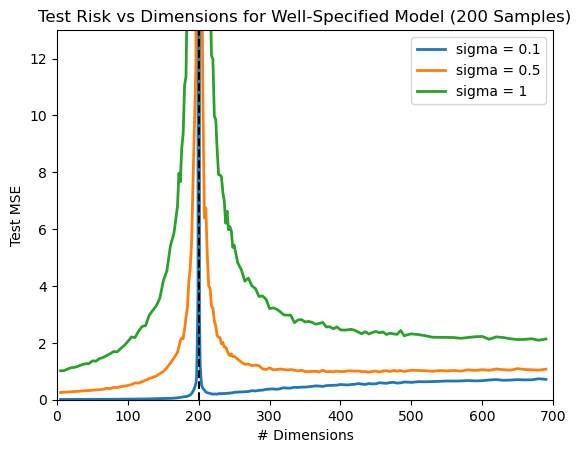

In [48]:
avgs_test_s1 = torch.mean(test_mse_s1, 1)
avgs_test_s2 = torch.mean(test_mse_s2, 1)
avgs_test_s3 = torch.mean(test_mse_s3, 1)

avgs_train_s1 = torch.mean(train_mse_s1, 1)
avgs_train_s2 = torch.mean(train_mse_s2, 1)
avgs_train_s3 = torch.mean(train_mse_s3, 1)

plt.title("Test Risk vs Dimensions for Well-Specified Model (200 Samples)")
plt.xlabel("# Dimensions")
plt.ylabel("Test MSE")
plt.ylim(0, 13)
plt.xlim(0, max_dim)
plt.plot(d_vals.cpu().numpy(), avgs_test_s1.cpu().numpy(), lw=2, label='sigma = 0.1')
plt.plot(d_vals.cpu().numpy(), avgs_test_s2.cpu().numpy(), lw=2, label='sigma = 0.5')
plt.plot(d_vals.cpu().numpy(), avgs_test_s3.cpu().numpy(), lw=2, label='sigma = 1')
plt.axvline(x=n, color='black', ls='--')
plt.legend(loc="best")
plt.show()

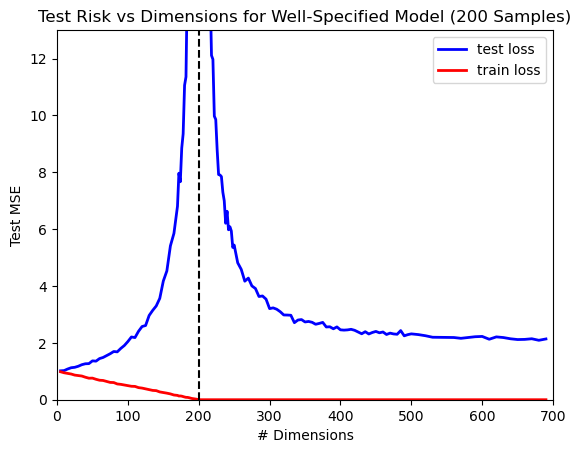

In [47]:
avgs_test_s1 = torch.mean(test_mse_s1, 1)
avgs_test_s2 = torch.mean(test_mse_s2, 1)
avgs_test_s3 = torch.mean(test_mse_s3, 1)

avgs_train_s1 = torch.mean(train_mse_s1, 1)
avgs_train_s2 = torch.mean(train_mse_s2, 1)
avgs_train_s3 = torch.mean(train_mse_s3, 1)

plt.title("Test Risk vs Dimensions for Well-Specified Model (200 Samples)")
plt.xlabel("# Dimensions")
plt.ylabel("Test MSE")
plt.ylim(0, 13)
plt.xlim(0, max_dim)
plt.plot(d_vals.cpu().numpy(), avgs_test_s3.cpu().numpy(),  lw=2, color='blue',
         label='test loss')
plt.plot(d_vals.cpu().numpy(), avgs_train_s3.cpu().numpy(), lw=2, color='red',
         label='train loss')
plt.axvline(x=n, color='black', ls='--')
plt.legend(loc="best")
plt.show()